In [9]:
# Import the necessary libraries and dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
import re
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Read the data
data = pd.read_csv("C:\Data\housing.csv")

# Filter the data
data = data[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Fill missing values with zeros
data['total_bedrooms'].fillna(0, inplace=True)

# Apply log transform to median_house_value
data['median_house_value'] = np.log1p(data['median_house_value'])

# Perform train/validation/test split with a 60%/20%/20% distribution
df_train, df_val_test = train_test_split(data, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=1)

# Initialize training features
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "ocean_proximity"]

# Convert data to dictionaries
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

# Initialize DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values

# Question 1
# Train a decision tree regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# Print the feature used for splitting the data
from sklearn.tree import export_text
tree_rules = export_text(dt, feature_names=list(dv.get_feature_names_out()))
print(tree_rules)

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [11]:
# Question 2
# Train a random forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Calculate RMSE on the validation set
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.23494749481338612


  0%|          | 0/20 [00:00<?, ?it/s]

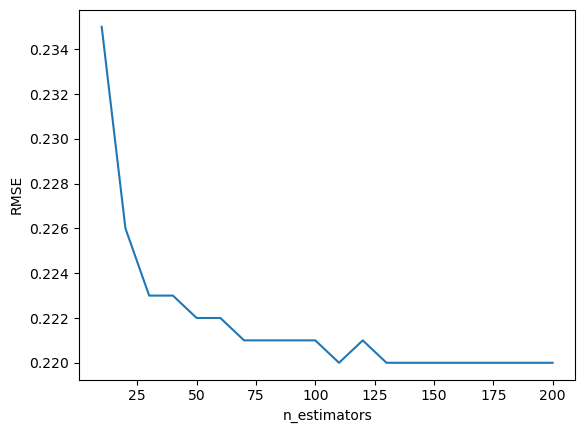

    n_estimators      rmse
14           150  0.220144


In [12]:
# Question 3
# Experiment with the n_estimators parameter
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

# Plot RMSE scores
plt.plot(df_scores['n_estimators'], df_scores['rmse'].round(3))
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

# After which value of n_estimators does RMSE stop improving?
print(df_scores[df_scores['rmse'] == df_scores['rmse'].min()])

In [13]:
# Question 4
# Select the best max_depth
scores = []

for d in [10, 15, 20, 25]:
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((d, n, score))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

# Calculate the mean RMSE for each max_depth
mean_rmse = df_scores.groupby('max_depth')['rmse'].mean()
best_max_depth = mean_rmse.idxmin()
print(f'Best max_depth: {best_max_depth}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best max_depth: 25


In [35]:
# Find the most important feature in a random forest model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Get feature names using get_feature_names_out()
feature_names = dv.get_feature_names_out()

# Create a DataFrame to display feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort by importance in descending order
df_importances = df_importances.sort_values(by='importance', ascending=False)

# Print the top feature
print(df_importances.iloc[0])


feature       median_income
importance         0.338044
Name: 4, dtype: object


In [44]:
# Question 6: XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params_0_3 = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_0_3 = xgb.train(xgb_params_0_3, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

xgb_params_0_1 = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_0_1 = xgb.train(xgb_params_0_1, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

rmse_0_3 = model_0_3.eval(dval)
rmse_0_1 = model_0_1.eval(dval)

print(f"RMSE for eta=0.3: {rmse_0_3}")
print(f"RMSE for eta=0.1: {rmse_0_1}")


[0]	train-rmse:0.44258	val-rmse:0.44336
[5]	train-rmse:0.25176	val-rmse:0.26474
[10]	train-rmse:0.21631	val-rmse:0.24121
[15]	train-rmse:0.19798	val-rmse:0.23304
[20]	train-rmse:0.18518	val-rmse:0.22786
[25]	train-rmse:0.17484	val-rmse:0.22399
[30]	train-rmse:0.16752	val-rmse:0.22247
[35]	train-rmse:0.16119	val-rmse:0.22118
[40]	train-rmse:0.15444	val-rmse:0.21964
[45]	train-rmse:0.14841	val-rmse:0.21817
[50]	train-rmse:0.14353	val-rmse:0.21757
[55]	train-rmse:0.13892	val-rmse:0.21717
[60]	train-rmse:0.13471	val-rmse:0.21619
[65]	train-rmse:0.13026	val-rmse:0.21590
[70]	train-rmse:0.12744	val-rmse:0.21604
[75]	train-rmse:0.12357	val-rmse:0.21557
[80]	train-rmse:0.12082	val-rmse:0.21559
[85]	train-rmse:0.11825	val-rmse:0.21554
[90]	train-rmse:0.11604	val-rmse:0.21530
[95]	train-rmse:0.11241	val-rmse:0.21565
[99]	train-rmse:0.10935	val-rmse:0.21539
[0]	train-rmse:0.52259	val-rmse:0.52103
[5]	train-rmse:0.37677	val-rmse:0.38047
[10]	train-rmse:0.30297	val-rmse:0.31079
[15]	train-rmse:0.26